<a href="https://colab.research.google.com/github/1c-chen/NLP/blob/main/NLP_hw01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd

In [50]:
!wget http://download.tensorflow.org/data/questions-words.txt


--2024-09-24 09:32:59--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.212.207, 173.194.210.207, 74.125.139.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.212.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt.1’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.003s  

2024-09-24 09:33:00 (220 MB/s) - ‘questions-words.txt.1’ saved [603955/603955]



In [51]:
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [52]:
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [53]:
sub_categories=[]
questions=[]
current_cat=None
for line in data:
  if line.startswith(':'):
    current_cat=line
  else:
    sub_categories.append(current_cat)
    questions.append(line)


In [54]:
set(sub_categories)
semantic=[': capital-common-countries',
 ': capital-world',
 ': city-in-state',
 ': currency',
 ': family']

categories=[]

for cat in sub_categories:
  if cat in semantic:
    categories.append('Semantic')
  else:
    categories.append('Syntactic')


In [34]:
df=pd.DataFrame({
    "Question": questions,
    "Category": categories,
    "SubCategory": sub_categories
})

In [35]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [37]:
df.to_csv(f"{file_name}.csv", index=False)

In [24]:
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [25]:
data = pd.read_csv("questions-words.csv")

In [45]:
data.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [69]:
MODEL_NAME = "glove-wiki-gigaword-100"
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model_pretrain = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")


The Gensim model loaded successfully!


In [70]:
preds1 = []
golds1 = []
for analogy in tqdm(data["Question"]):
    # Split the question into four words (e.g., "Athens", "Greece", "Baghdad", "Iraq")
    words = analogy.split()
    if len(words) != 4:
        continue  # skip invalid questions

    # Extract the gold answer (word_d)
    word_a, word_b, word_c, word_d = words
    golds1.append(word_d)  # Preserve the correct answer for later evaluation

    try:
        # Use word vectors to predict the analogy answer using vector arithmetic
        predicted = model_pretrain.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds1.append(predicted[0][0])  # Store the predicted word
    except KeyError:
        preds1.append(None)  # Handle cases where a word is not in the model's vocabulary

100%|██████████| 19544/19544 [05:22<00:00, 60.57it/s]


In [71]:
def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds1), np.array(preds1)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category {sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 4.656669297553275%
Category: Syntactic, Accuracy: 48.09367681498829%
Sub-Category : capital-common-countries, Accuracy: 0.0%
Sub-Category : capital-world, Accuracy: 0.0%
Sub-Category : currency, Accuracy: 0.0%
Sub-Category : city-in-state, Accuracy: 0.0%
Sub-Category : family, Accuracy: 81.62055335968378%
Sub-Category : gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category : gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category : gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category : gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category : gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category : gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category : gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category : gram8-plural, Accuracy: 71.996996996997%
Sub-Category : gram9-plural-verbs, Accuracy: 58.39080459770115%


In [73]:
word_list=[]
for question in data[data['SubCategory']==': family']['Question']:
  for word in question.split():
    word_list.append(word)
unique_list=list(set(word_list))
word_vec=[]
word_label=[]
for word in unique_list:
  word_vec.append(model_pretrain[word])
  word_label.append(word)
word_vec_np=np.array(word_vec)

In [77]:
tsne = TSNE(n_components=2, random_state=1)
word_vec_tsne = tsne.fit_transform(word_vec_np)

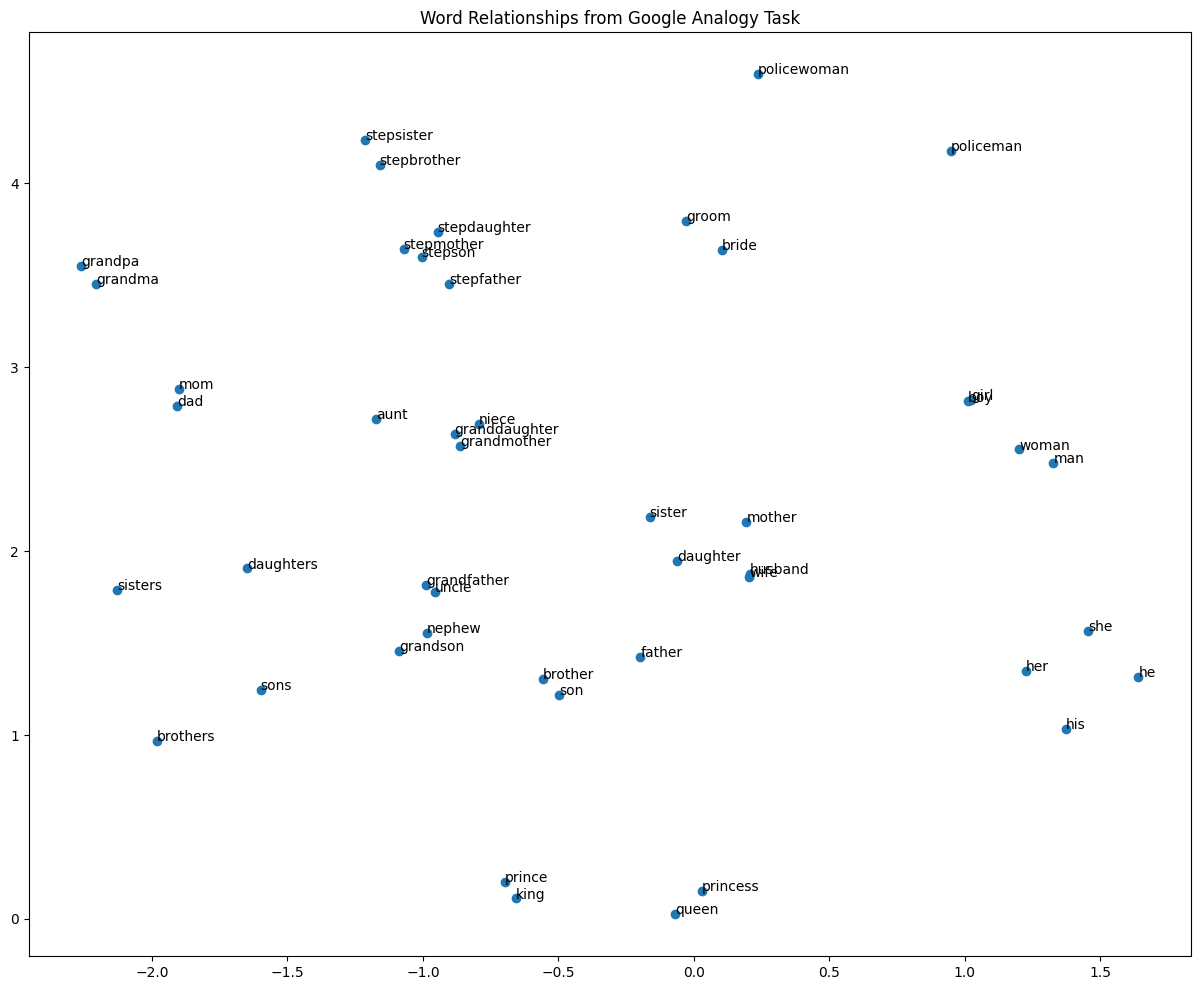

<Figure size 640x480 with 0 Axes>

In [78]:
plt.figure(figsize=(15,12))
plt.scatter(word_vec_tsne[:, 0], word_vec_tsne[:, 1], marker='o')
for i, label in enumerate(word_label):
    plt.annotate(label, (word_vec_tsne[i, 0], word_vec_tsne[i, 1]))

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")


In [1]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=6b09f894-70ea-4927-9293-f9264012a191
To: /content/wiki_texts_part_0.txt.gz
100% 1.51G/1.51G [00:29<00:00, 51.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG
From (redirected): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG&confirm=t&uuid=c0710e5b-3736-4b96-ae9e-59616a6ba220
To: /content/

In [2]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=eb0c0ed4-d299-4ba0-811c-214a785fdf5b
To: /content/wiki_texts_part_5.txt.gz
100% 578M/578M [00:07<00:00, 77.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P
From (redirected): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P&confirm=t&uuid=a110c9fe-aab3-477b-8647-01a5bd683f8a
To: /content/wi

In [3]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz


In [4]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [5]:
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

In [6]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "sampled_wiki_texts.txt"

with open(wiki_txt_path, "r", encoding="utf-8") as f:
  with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
    for line in f:
      if random.random()<0.2:
        output_file.write(line)

 character style thought spectacle and lyric poetry the characters in tragedy are merely means of driving the story and the plot not the characters is the chief focus of tragedy tragedy is the imitation of action arousing pity and fear and is meant to effect the catharsis of those same emotions aristotle concludes poetics with discussion on which if either is superior epic or tragic mimesis he suggests that because tragedy possesses all the attributes of an epic possibly possesses additional attributes such as spectacle and music is more unified and achieves the aim of its mimesis in shorter scope it can be considered superior to epic aristotle was keen systematic collector of riddles folklore and proverbs he and his school had special interest in the riddles of the delphic oracle and studied the fables of aesop gender and sexuality aristotle asserted that men were superior to women writing the male is by nature superior and the female inferior the male ruler and the female subject on 

In [10]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from tqdm import tqdm

# 初始化 Word2Vec 模型
model = Word2Vec(vector_size=100, window=5, min_count=20, epochs=3)

# 使用 LineSentence 流式讀取文件進行詞彙表構建
sentences = LineSentence("sampled_wiki_texts.txt")
model.build_vocab(sentences)

# 使用 tqdm 顯示進度條
total_examples = model.corpus_count

# 迴圈內重新加載生成器並進行訓練
for epoch in range(model.epochs):
    print(f"Training epoch {epoch+1}/{model.epochs}")

    # 每個 epoch 開始時重新加載 sentences 生成器
    sentences = LineSentence("sampled_wiki_texts.txt")

    # 使用 tqdm 包裝 sentences 來顯示進度
    model.train(tqdm(sentences, total=total_examples), total_examples=total_examples, epochs=1)

# 保存模型
model.save("word2vec.model")


Training epoch 1/3


100%|██████████| 1126851/1126851 [40:03<00:00, 468.79it/s]


Training epoch 2/1


100%|██████████| 1126851/1126851 [37:25<00:00, 501.72it/s]


Training epoch 3/1


100%|██████████| 1126851/1126851 [38:12<00:00, 491.45it/s]


In [62]:
model = Word2Vec.load("word2vec.model")

In [64]:
preds = []
golds = []
for analogy in tqdm(data["Question"]):
    # Split the question into four words (e.g., "Athens", "Greece", "Baghdad", "Iraq")
    words = analogy.split()
    if len(words) != 4:
        continue  # skip invalid questions

    # Extract the gold answer (word_d)
    word_a, word_b, word_c, word_d = words
    golds.append(word_d)  # Preserve the correct answer for later evaluation

    try:
        # Use word vectors to predict the analogy answer using vector arithmetic
        predicted=model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        #predicted = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        preds.append(predicted[0][0])  # Store the predicted word
    except KeyError:
        preds.append(None)  # Handle cases where a word is not in the model's vocabulary

100%|██████████| 19544/19544 [06:30<00:00, 50.03it/s]


In [65]:
def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category {sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 4.769421580787011%
Category: Syntactic, Accuracy: 37.50819672131148%
Sub-Category : capital-common-countries, Accuracy: 0.0%
Sub-Category : capital-world, Accuracy: 0.0%
Sub-Category : currency, Accuracy: 0.0%
Sub-Category : city-in-state, Accuracy: 0.0%
Sub-Category : family, Accuracy: 83.59683794466403%
Sub-Category : gram1-adjective-to-adverb, Accuracy: 17.540322580645164%
Sub-Category : gram2-opposite, Accuracy: 17.610837438423648%
Sub-Category : gram3-comparative, Accuracy: 70.42042042042041%
Sub-Category : gram4-superlative, Accuracy: 40.017825311942964%
Sub-Category : gram5-present-participle, Accuracy: 41.571969696969695%
Sub-Category : gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category : gram7-past-tense, Accuracy: 49.358974358974365%
Sub-Category : gram8-plural, Accuracy: 48.94894894894895%
Sub-Category : gram9-plural-verbs, Accuracy: 50.45977011494253%


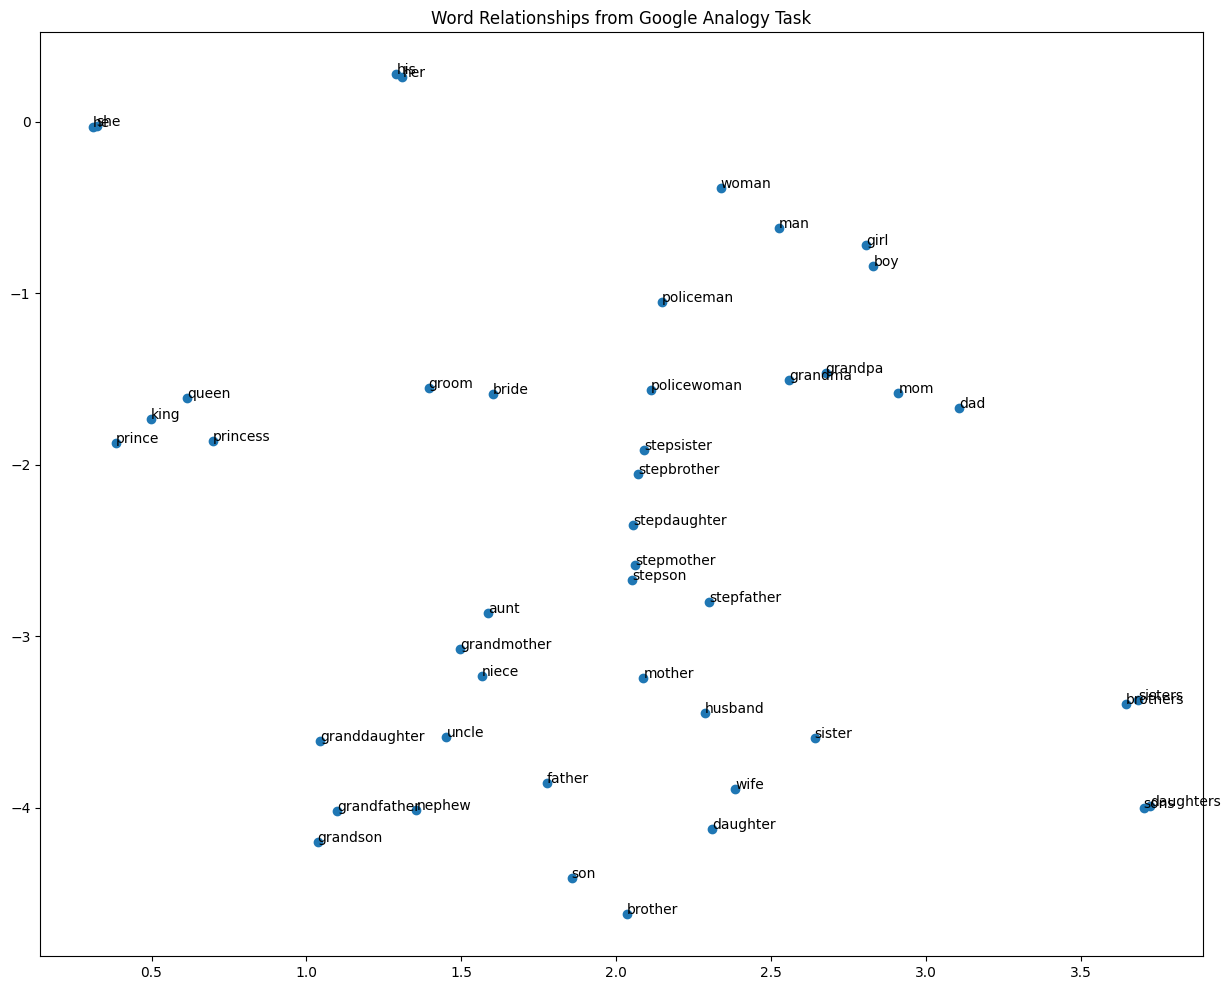

<Figure size 640x480 with 0 Axes>

In [79]:
word_list=[]
for question in data[data['SubCategory']==': family']['Question']:
  for word in question.split():
    word_list.append(word)
unique_list=list(set(word_list))
word_vec=[]
word_label=[]
for word in unique_list:
  word_vec.append(model.wv[word])
  word_label.append(word)
word_vec_np=np.array(word_vec)

tsne = TSNE(n_components=2, random_state=1)
word_vec_tsne = tsne.fit_transform(word_vec_np)

plt.figure(figsize=(15,12))
plt.scatter(word_vec_tsne[:, 0], word_vec_tsne[:, 1], marker='o')
for i, label in enumerate(word_label):
    plt.annotate(label, (word_vec_tsne[i, 0], word_vec_tsne[i, 1]))

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

In [82]:
import re
import spacy
import nltk
from nltk.corpus import stopwords


In [83]:
def remove_non_eng(text):
  return re.sub(r"[^a-zA-Z\s]", '', text)

In [84]:
nlp=spacy.load('en_core_web_sm')
def better_tokenization(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [85]:
def lemmatize_text(text):
    # 使用 spaCy 進行詞形還原
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc]

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stop_words(token):
  return [word for word in token if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocessing(text):
  #text=remove_non_eng(text)
  tokens = better_tokenization(text)
  tokens = remove_stop_words(tokens)
  tokens = lemmatize_text(tokens)
  return tokens


In [ ]:
import re
from gensim.models import Word2Vec

# 自定義生成器函數，逐行讀取文件並分詞
def sentences_generator(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            # 預處理每行文本，例如移除非英文字母並分詞
            tokens = preprocessing(line)  # 移除非英文字母
            tokens
            if tokens:
                yield tokens  # 使用 yield 返回生成器

# 構建模型
model = Word2Vec(vector_size=100, window=5, min_count=5, workers=4)

# 使用生成器進行流式訓練
sentences = sentences_generator("sampled_wiki_texts1.txt")

# 構建詞彙表
model.build_vocab(sentences)

# 重新生成一個流式數據集，並進行模型訓練
sentences = sentences_generator("sampled_wiki_texts1.txt")
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

# 保存模型
model.save("word2vec.model")


131958it [00:42, 5036.20it/s]

In [31]:
!ls -l


total 51834448
-rw-r--r-- 1 root root     1173779 Sep 24 08:59 questions-words.csv
-rw-r--r-- 1 root root      603955 Jul 22  2016 questions-words.txt
drwxr-xr-x 1 root root        4096 Sep 20 13:22 sample_data
-rw-r--r-- 1 root root  4157331618 Sep 24 06:47 sampled_wiki_texts.txt
-rw-r--r-- 1 root root 20817736935 Sep 24 06:43 wiki_texts_combined.txt
-rw-r--r-- 1 root root  4585604461 Sep 16 16:23 wiki_texts_part_0.txt
-rw-r--r-- 1 root root  1508978944 Sep 16 16:23 wiki_texts_part_0.txt.gz
-rw-r--r-- 1 root root        6258 Sep 17 02:10 wiki_texts_part_10.txt
-rw-r--r-- 1 root root        2821 Sep 17 02:10 wiki_texts_part_10.txt.gz
-rw-r--r-- 1 root root  2478616738 Sep 16 16:18 wiki_texts_part_1.txt
-rw-r--r-- 1 root root   836329624 Sep 16 16:18 wiki_texts_part_1.txt.gz
-rw-r--r-- 1 root root  1976998216 Sep 16 16:16 wiki_texts_part_2.txt
-rw-r--r-- 1 root root   665204031 Sep 16 16:16 wiki_texts_part_2.txt.gz
-rw-r--r-- 1 root root  1782493879 Sep 16 17:05 wiki_texts_part_3.txt
-r

In [2]:
!nproc


2


In [ ]:
with open("sampled_wiki_texts1.txt", "r", encoding="utf-8") as f:
    line_count = sum(1 for line in f)

print(f"Total number of lines: {line_count}")

Total number of lines: 1123406


In [ ]:
with open("sampled_wiki_texts1.txt", "r", encoding="utf-8") as file:
  for line in f:

